In [1]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)
print(gpu[0])

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# 1. Import Libraries

In [2]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from geopy.distance import distance

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, Adam,  RMSprop, Nadam
from tensorflow.keras.layers import Dense, Flatten,  LSTM, GRU, LeakyReLU, Dropout, Bidirectional

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import  MinMaxScaler, PowerTransformer

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import (
    AdaBoostRegressor,
    BaggingRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor, 
    HistGradientBoostingRegressor,
    RandomForestRegressor,
    StackingRegressor,
)
from xgboost import XGBRegressor

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly


# 2. Load Data

In [3]:
data = pd.read_csv('../Dataset/electricity.csv', delimiter=';', low_memory=False).dropna()
data.head(5)

,DateTime,Holiday,HolidayFlag,DayOfWeek,WeekOfYear,Day,Month,Year,PeriodOfDay,ForecastWindProduction,SystemLoadEA,SMPEA,ORKTemperature,ORKWindspeed,CO2Intensity,ActualWindProduction,SystemLoadEP2,SMPEP2
0,01/11/2011 00:00,None,0,1,44,1,11,2011,0,315.31,3388.77,49.26,6.00,9.30,600.71,356.00,3159.60,54.32
1,01/11/2011 00:30,None,0,1,44,1,11,2011,1,321.80,3196.66,49.26,6.00,11.10,605.42,317.00,2973.01,54.23
2,01/11/2011 01:00,None,0,1,44,1,11,2011,2,328.57,3060.71,49.10,5.00,11.10,589.97,311.00,2834.00,54.23
3,01/11/2011 01:30,None,0,1,44,1,11,2011,3,335.60,2945.56,48.04,6.00,9.30,585.94,313.00,2725.99,53.47
4,01/11/2011 02:00,None,0,1,44,1,11,2011,4,342.90,2849.34,33.75,6.00,11.10,571.52,346.00,2655.64,39.87


# 3. Initial Analysis

### 3.1. Metadata

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37682 entries, 0 to 38013
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   DateTime                37682 non-null  object 
 1   Holiday                 37682 non-null  int32  
 2   HolidayFlag             37682 non-null  int64  
 3   DayOfWeek               37682 non-null  int64  
 4   WeekOfYear              37682 non-null  int64  
 5   Day                     37682 non-null  int64  
 6   Month                   37682 non-null  int64  
 7   Year                    37682 non-null  int64  
 8   PeriodOfDay             37682 non-null  int64  
 9   ForecastWindProduction  37682 non-null  float64
 10  SystemLoadEA            37682 non-null  float64
 11  SMPEA                   37682 non-null  float64
 12  ORKTemperature          37682 non-null  float64
 13  ORKWindspeed            37682 non-null  float64
 14  CO2Intensity            37682 non-null

In [11]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Holiday,37682.0,10.852237,1.126123,0.00,11.0000,11.000,11.0000,14.00
HolidayFlag,37682.0,0.037578,0.190175,0.00,0.0000,0.000,0.0000,1.00
DayOfWeek,37682.0,2.998355,1.998845,0.00,1.0000,3.000,5.0000,6.00
WeekOfYear,37682.0,28.044584,15.552428,1.00,14.0000,29.000,43.0000,52.00
Day,37682.0,15.707181,8.804424,1.00,8.0000,16.000,23.0000,31.00
Month,37682.0,6.886789,3.566915,1.00,4.0000,7.000,10.0000,12.00
Year,37682.0,2012.386577,0.623780,2011.00,2012.0000,2012.000,2013.0000,2013.00
PeriodOfDay,37682.0,23.508651,13.854822,0.00,12.0000,24.000,36.0000,47.00
ForecastWindProduction,37682.0,542.871513,413.725304,0.68,188.9275,440.645,837.1825,1680.00
SystemLoadEA,37682.0,4020.753657,860.148265,2183.94,3281.7800,4105.530,4638.9825,6492.91


In [8]:
data.isnull().sum()

DateTime                  0
Holiday                   0
HolidayFlag               0
DayOfWeek                 0
WeekOfYear                0
Day                       0
Month                     0
Year                      0
PeriodOfDay               0
ForecastWindProduction    0
SystemLoadEA              0
SMPEA                     0
ORKTemperature            0
ORKWindspeed              0
CO2Intensity              0
ActualWindProduction      0
SystemLoadEP2             0
SMPEP2                    0
dtype: int64

In [9]:
data.duplicated().sum()

0

### 3.2. Columns Processing

In [4]:
columns = ['ForecastWindProduction', 'SystemLoadEA', 'SMPEA', 'ORKTemperature', 'ORKWindspeed', 'CO2Intensity', 'ActualWindProduction', 'SystemLoadEP2', 'SMPEP2']

data = data[~data[columns].apply(lambda x: x.str.contains('\?')).any(axis=1)]

In [5]:
def change_dtypes(data):
    data["ForecastWindProduction"] = pd.to_numeric(data["ForecastWindProduction"], errors= 'coerce')
    data["SystemLoadEA"] = pd.to_numeric(data["SystemLoadEA"], errors= 'coerce')
    data["SMPEA"] = pd.to_numeric(data["SMPEA"], errors= 'coerce')
    data["ORKTemperature"] = pd.to_numeric(data["ORKTemperature"], errors= 'coerce')
    data["ORKWindspeed"] = pd.to_numeric(data["ORKWindspeed"], errors= 'coerce')
    data["CO2Intensity"] = pd.to_numeric(data["CO2Intensity"], errors= 'coerce')
    data["ActualWindProduction"] = pd.to_numeric(data["ActualWindProduction"], errors= 'coerce')
    data["SystemLoadEP2"] = pd.to_numeric(data["SystemLoadEP2"], errors= 'coerce')
    data["SMPEP2"] = pd.to_numeric(data["SMPEP2"], errors= 'coerce')
    return data

data = change_dtypes(data)

In [6]:
LE = LabelEncoder()

data['Holiday'] = LE.fit_transform(data['Holiday'])

In [7]:
numerical_columns = [column_name for column_name in data.columns if data[column_name].dtype != 'object']
categorical_columns = [column_name for column_name in data.columns if data[column_name].dtype == 'object']

print(f'Numerical Columns Train   : {numerical_columns}')
print(f'Categorical Columns Train : {categorical_columns}')

Numerical Columns Train   : ['Holiday', 'HolidayFlag', 'DayOfWeek', 'WeekOfYear', 'Day', 'Month', 'Year', 'PeriodOfDay', 'ForecastWindProduction', 'SystemLoadEA', 'SMPEA', 'ORKTemperature', 'ORKWindspeed', 'CO2Intensity', 'ActualWindProduction', 'SystemLoadEP2', 'SMPEP2']
Categorical Columns Train : ['DateTime']


In [ ]:
# def change_dtypes(data):
#     data['ForecastWindProduction'] = data['ForecastWindProduction'].astype(float)
#     data['SystemLoadEA'] = data['SystemLoadEA'].astype(float)
#     data['SMPEA'] = data['SMPEA'].astype(float)
#     data['ORKTemperature'] = data['ORKTemperature'].astype(float)
#     data['ORKWindspeed'] = data['ORKWindspeed'].astype(float)
#     data['CO2Intensity'] = data['CO2Intensity'].astype(float)
#     data['ActualWindProduction'] = data['ActualWindProduction'].astype(float)
#     data['SystemLoadEP2'] = data['SystemLoadEP2'].astype(float)
#     data['SMPEP2'] = data['SMPEP2'].astype(float)
#     return data
# data = change_dtypes(data)

In [14]:
# data = data[np.isfinite(data[numerical_columns]).all(1)]

In [21]:
# data = data[~data.isin([np.nan, np.inf, -np.inf]).all(1)]

# 4. EDA

<Axes: xlabel='SMPEP2'>

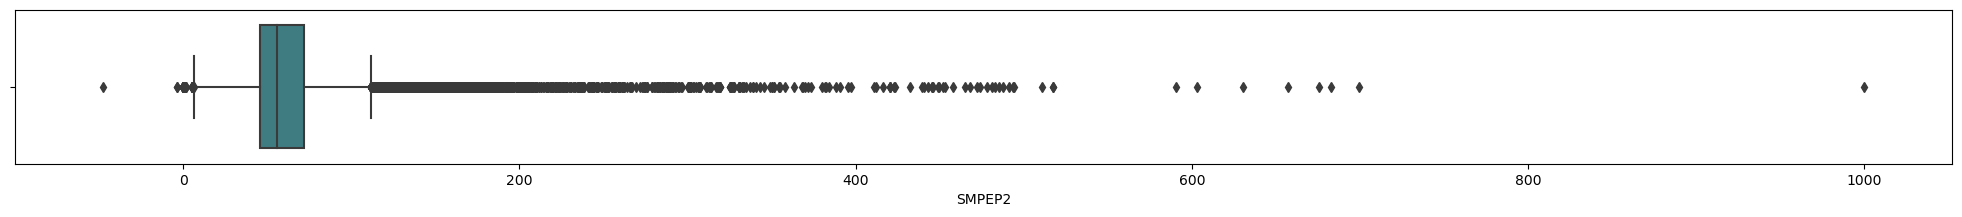

In [8]:
fig, ax = plt.subplots(figsize=(25, 2))
sns.boxplot(x=data['SMPEP2'], palette="crest")

In [10]:
print(data['SMPEP2'].quantile(0.25))
print(data['SMPEP2'].quantile(0.75))

45.8
72.12


<Axes: xlabel='SMPEP2'>

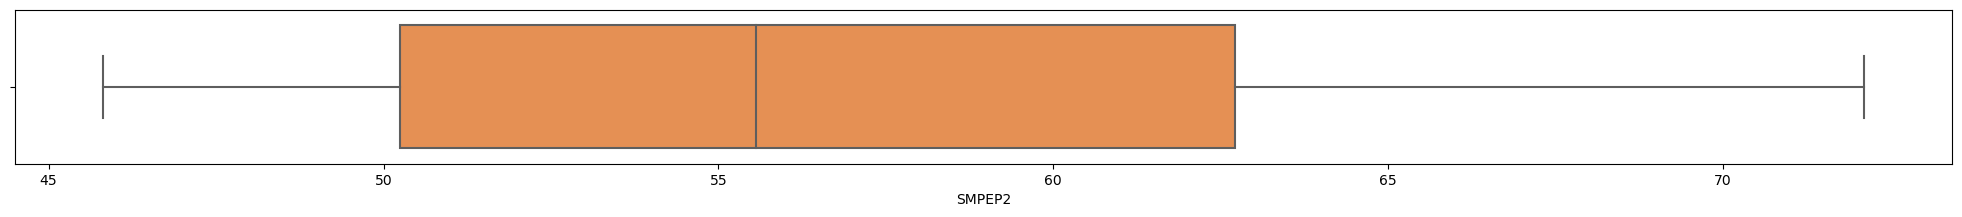

In [11]:
Q1 = data['SMPEP2'].quantile(.25)
Q3 = data['SMPEP2'].quantile(.75)

data = data[(data['SMPEP2'] > Q1) & (data['SMPEP2'] < Q3)]

fig, axes = plt.subplots(figsize=(25, 2))
sns.boxplot(x = data['SMPEP2'], palette="Oranges")

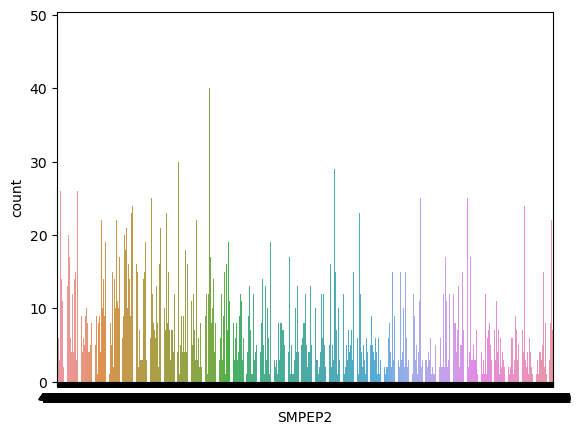

In [12]:
ax = sns.countplot(data, x = data['SMPEP2'])

C:\Users\indiz\AppData\Local\Temp\ipykernel_1948\2705066046.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_data = data.corr().round(2)


Text(0.5, 1.0, 'Correlation Matrix')

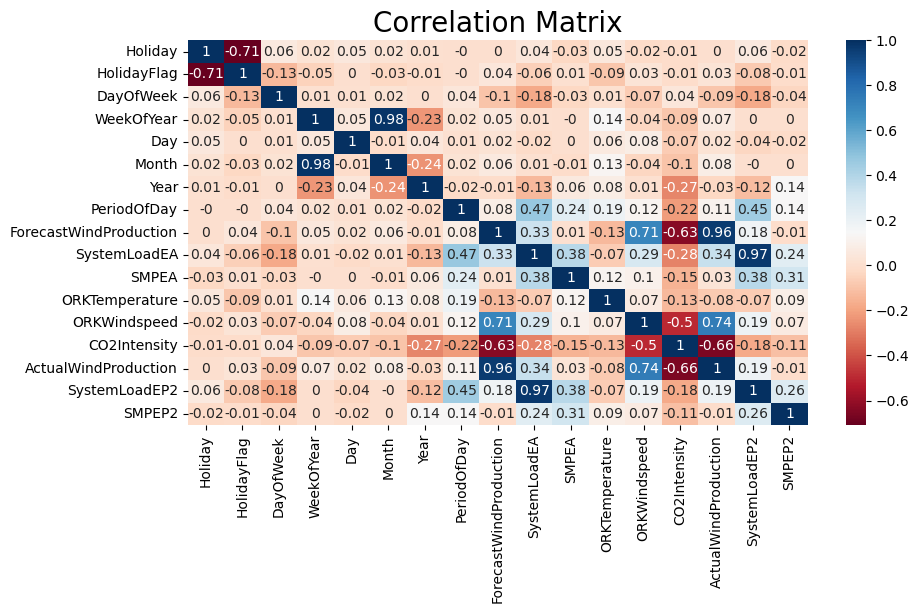

In [13]:
corr_data = data.corr().round(2)

plt.figure(figsize=(10, 5))
sns.heatmap(corr_data, annot=True, cmap='RdBu')
plt.title("Correlation Matrix", size=20)

# 5. Regression Algoritms

In [23]:
# X = data.drop(columns=['DateTime', 'SMPEP2'])
X = data[["Day", "Month", 'PeriodOfDay', "ForecastWindProduction", "SystemLoadEA", 
        "SMPEA", "ORKTemperature", "ORKWindspeed", "CO2Intensity", 
        "ActualWindProduction", "SystemLoadEP2"]]
Y = data['SMPEP2']

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size = 0.8, random_state = 42)

scalar = PowerTransformer(method='yeo-johnson', standardize=True).fit(X_train)
X_train = scalar.transform(X_train)
X_test = scalar.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(30145, 11)
(7537, 11)


In [24]:
adaboost = AdaBoostRegressor(n_estimators = 100, random_state = 42)
bagging = BaggingRegressor(n_jobs = -1)
extraTrees = ExtraTreesRegressor(max_depth = 100, n_jobs = -1, random_state = 42)
gradient = GradientBoostingRegressor(max_depth = 100, n_estimators = 100, learning_rate = .01,  random_state = 0)
randomForest = RandomForestRegressor(max_depth = 100, random_state = 42, n_jobs = -1)
histGradient = HistGradientBoostingRegressor()
XGB = XGBRegressor(n_jobs = -1)
knn = KNeighborsRegressor(n_jobs = -1)
decisionTree = DecisionTreeRegressor( max_depth = 100, random_state = 42)

model = StackingRegressor([
    ('extraTrees', extraTrees),
    # ('randomforest', randomForest),
    # ('bagging', bagging),
    # ('gradient', gradient),
    # ('decisionTree', decisionTree),
    # ('XGB', XGB),
    # ('adaboost', adaboost),
    # ('histGradient', histGradient),
    # ('knn', knn),
], n_jobs=-1)

In [25]:
model.fit(X_train, y_train)

StackingRegressor(estimators=[('extraTrees',
                               ExtraTreesRegressor(max_depth=100, n_jobs=-1,
                                                   random_state=42))],
                  n_jobs=-1)

In [26]:
print("Train Score        :",round((model.score(X_train, y_train)*100), 2),'%')
print("Test Score         :",round((model.score(X_test, y_test)*100), 2),'%')

y_pred = model.predict(X_test)

print("R Squared Error    :",round(r2_score(y_test, y_pred), 2))
print("Mean Squared Error :",round(mean_squared_error(y_test, y_pred), 2))

Train Score        : 99.98 %
Test Score         : 59.85 %
R Squared Error    : 0.6
Mean Squared Error : 521.53


In [90]:
train_predictions = model.predict(X_test).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_test})
train_results['Diff'] = abs(train_results['Actuals'] - train_results['Train Predictions'])
print(train_results.head(5))
print(train_results['Diff'].mean(), '-', (train_results['Diff'].sum()))

       Train Predictions  Actuals      Diff
32745          45.426660    48.32  2.893340
14933          52.359393    60.06  7.700607
35033          57.511873    48.63  8.881873
19028          63.370861    59.72  3.650861
444            44.948509    43.38  1.568509
10.071029245634175 - 75905.34742434479


In [89]:
print(train_results['Diff'].mean())

10.071029245634175


# 6. Neural Network

In [14]:
# X = data.drop(columns=['DateTime', 'SMPEP2'])
X = data[["Day", "Month", 'Holiday', 'HolidayFlag',
        "ForecastWindProduction", "SystemLoadEA", 
        "SMPEA", "ORKTemperature", "ORKWindspeed", "CO2Intensity", 
        "ActualWindProduction", "SystemLoadEP2"]]
Y = data['SMPEP2']

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

scalar = PowerTransformer(method='yeo-johnson', standardize=True)
# scalar = MinMaxScaler(feature_range=(0,1))
X_train = scalar.fit_transform(X_train)
X_test = scalar.fit_transform(X_test)
X_val = scalar.fit_transform(X_val)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(13217, 12)
(3729, 12)
(1883, 12)


In [49]:
def DNN_Model():
    model = Sequential()
    model.add(Dense(1024, activation='relu', kernel_initializer='he_uniform', input_shape=(X_train.shape[1],)))
    # model.add(Dropout(0.5))
    # model.add(Dense(256, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(1, activation='linear', kernel_initializer='he_uniform'))
    
    return model

def LSTM_Model():
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    # model.add(LSTM(64))
    model.add(Dense(32, activation='relu'))
    # model.add(Dropout(0.2))
    # model.add(Dropout(0.5))
    # model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    return model

def GRU_Model():
    model = Sequential()
    model.add(GRU(128, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True, input_shape = (X_train.shape[1],1)))
    model.add(GRU(64, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True))
    model.add(GRU(32, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True))
    # model.add(Dense(128, activation='relu'))
    # model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    return model

# model = DNN_Model()
# model = LSTM_Model()
model = GRU_Model()

model.summary()

# opt = SGD(learning_rate=0.01, momentum=0.9)
opt = Adam(learning_rate = 0.001)

# model.compile(loss='mse', optimizer=opt, metrics=['mse'])
model.compile(loss='mae', optimizer = opt)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_20 (GRU)                (None, 12, 128)           50304     
                                                                 
 gru_21 (GRU)                (None, 12, 64)            37248     
                                                                 
 gru_22 (GRU)                (None, 32)                9408      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 96,993
Trainable params: 96,993
Non-trainable params: 0
_________________________________________________________________


In [48]:
num_epoch = 100
batch_size = 64

history = model.fit(X_train, y_train, 
                    batch_size = batch_size, epochs = num_epoch,
                    validation_data = (X_val, y_val)
                    )

Epoch 1/100
207/207 [==============================] - 7s 17ms/step - loss: 46.1852 - val_loss: 42.3059
Epoch 2/100
207/207 [==============================] - 2s 11ms/step - loss: 38.7522 - val_loss: 35.3473
Epoch 3/100
207/207 [==============================] - 2s 11ms/step - loss: 31.8304 - val_loss: 28.4509
Epoch 4/100
207/207 [==============================] - 2s 11ms/step - loss: 24.9475 - val_loss: 21.5787
Epoch 5/100
207/207 [==============================] - 2s 10ms/step - loss: 18.0823 - val_loss: 14.7194
Epoch 6/100
207/207 [==============================] - 2s 10ms/step - loss: 11.3488 - val_loss: 8.6973
Epoch 7/100
207/207 [==============================] - 2s 10ms/step - loss: 7.4649 - val_loss: 6.9636
Epoch 8/100
207/207 [==============================] - 2s 11ms/step - loss: 6.5408 - val_loss: 6.5981
Epoch 9/100
207/207 [==============================] - 2s 11ms/step - loss: 6.3442 - val_loss: 6.5276
Epoch 10/100
207/207 [==============================] - 2s 12ms/step - 

KeyboardInterrupt: 

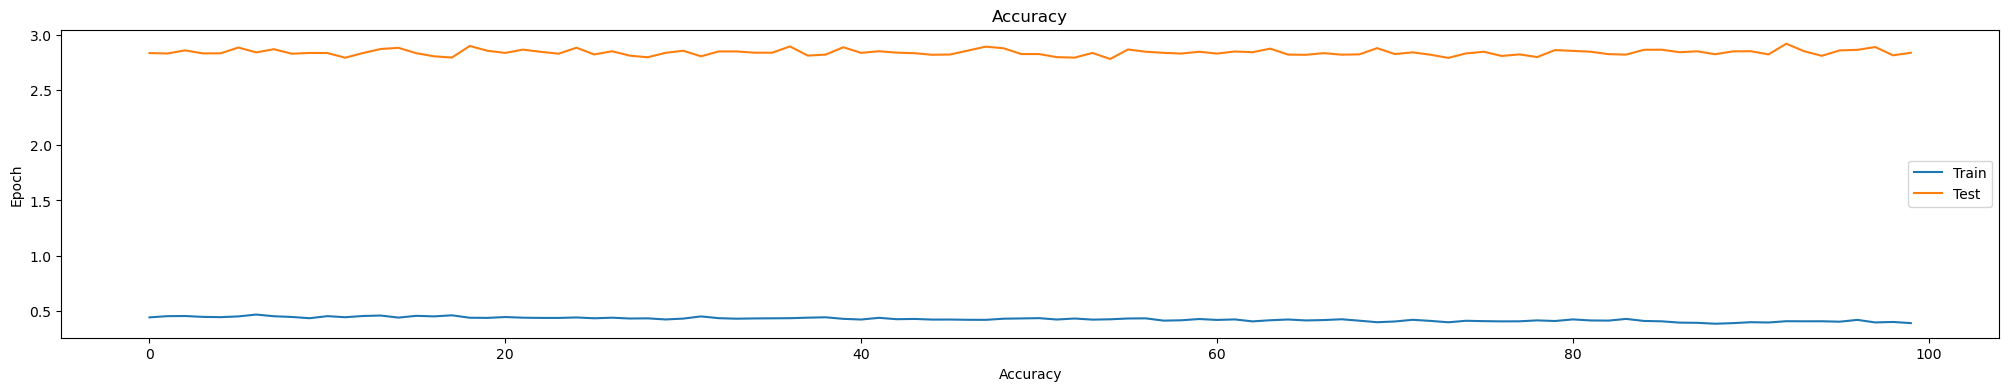

In [44]:
fig, ax = plt.subplots(figsize=(25, 4))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('Accuracy')
ax.set_xlabel('Accuracy')
ax.set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

In [35]:
y_pred = model.predict(X_test, verbose = 0)

print("R Squared Error    :",round(r2_score(y_test, y_pred), 2))
print("Mean Squared Error :",round(mean_squared_error(y_test, y_pred), 2))

R Squared Error    : 0.63
Mean Squared Error : 20.95


In [36]:
train_predictions = model.predict(X_test, verbose=0).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_test})
train_results['Diff'] = abs(train_results['Actuals'] - train_results['Train Predictions'])
print(train_results.head(5))
print(train_results['Diff'].mean(), '-', (train_results['Diff'].sum()))

       Train Predictions  Actuals      Diff
211            61.104187    66.58  5.475813
29747          60.951832    61.42  0.468168
11171          58.099155    62.34  4.240845
31621          47.476521    47.58  0.103479
25937          46.923855    47.09  0.166145
2.885994211464409 - 10761.87241455078


In [38]:
pred_df = data.copy()

# x_test = pred_df.drop(columns=['DateTime', 'SMPEP2'])
x_test = pred_df[["Day", "Month", 'Holiday', 'HolidayFlag',
        "ForecastWindProduction", "SystemLoadEA", 
        "SMPEA", "ORKTemperature", "ORKWindspeed", "CO2Intensity", 
        "ActualWindProduction", "SystemLoadEP2"]]
train_predictions = model.predict(x_test, verbose=0).flatten()

pred_df['Prediction'] = train_predictions
pred_df

,DateTime,Holiday,HolidayFlag,DayOfWeek,WeekOfYear,Day,Month,Year,PeriodOfDay,ForecastWindProduction,SystemLoadEA,SMPEA,ORKTemperature,ORKWindspeed,CO2Intensity,ActualWindProduction,SystemLoadEP2,SMPEP2,Prediction
0,01/11/2011 00:00,11,0,1,44,1,11,2011,0,315.31,3388.77,49.26,6.0,9.3,600.71,356.0,3159.60,54.32,57.716805
1,01/11/2011 00:30,11,0,1,44,1,11,2011,1,321.80,3196.66,49.26,6.0,11.1,605.42,317.0,2973.01,54.23,57.281536
2,01/11/2011 01:00,11,0,1,44,1,11,2011,2,328.57,3060.71,49.10,5.0,11.1,589.97,311.0,2834.00,54.23,57.436443
3,01/11/2011 01:30,11,0,1,44,1,11,2011,3,335.60,2945.56,48.04,6.0,9.3,585.94,313.0,2725.99,53.47,57.341980
12,01/11/2011 06:00,11,0,1,44,1,11,2011,12,339.22,3039.67,44.31,5.0,3.7,556.14,383.0,2842.19,51.45,62.123222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38005,31/12/2013 19:30,10,1,1,1,31,12,2013,39,1136.22,4286.95,74.84,6.0,22.2,311.24,1085.0,4447.42,62.05,-26.835670
38006,31/12/2013 20:00,10,1,1,1,31,12,2013,40,1160.57,4188.85,66.08,5.0,18.5,262.97,1143.0,4207.57,62.05,-27.030998
38007,31/12/2013 20:30,10,1,1,1,31,12,2013,41,1183.58,4122.26,65.39,5.0,20.4,264.71,941.0,4051.01,59.48,-26.955067
38008,31/12/2013 21:00,10,1,1,1,31,12,2013,42,1204.71,4000.49,63.32,5.0,18.5,266.03,913.0,3856.20,50.60,-27.050983
